In [1]:
import pandas as pd
import numpy as np
import h2o
import lime
from lime import lime_tabular

from sklearn.model_selection import train_test_split, KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.decomposition import PCA  # Principal component
from sklearn.linear_model import LinearRegression
from h2o.automl import H2OAutoML as ml
from h2o.estimators import H2OXGBoostEstimator

from functions.datacleaning import MoscowHousing as mh
from functions.clean import revert, write_predictions
from functions.distance import get_distance_coordinates, norm_features, PCA_plot

import matplotlib.pylab as plt
import seaborn as sns
plt.style.use('ggplot')

In [2]:
XTrain = pd.read_csv("../prepared_data/train_prepared_category_3.csv")
XTest = pd.read_csv("../prepared_data/test_prepared_category_3.csv")

In [3]:
""""
X_Train = XTrain.copy()
y_Train = XTrain["price"].copy()
y_Train = norm_features(y_Train)  # use z-scores to train

X_Test = XTest.copy()
drop_features = ["Unnamed: 0", 
                 "id", 
                 "street", 
                 "address"]
X_Train = X_Train.drop(drop_features, axis=1)
X_Train = X_Train.drop("price", axis=1)
X_Test = X_Test.drop(drop_features, axis=1)
"""

'"\nX_Train = XTrain.copy()\ny_Train = XTrain["price"].copy()\ny_Train = norm_features(y_Train)  # use z-scores to train\n\nX_Test = XTest.copy()\ndrop_features = ["Unnamed: 0", \n                 "id", \n                 "street", \n                 "address"]\nX_Train = X_Train.drop(drop_features, axis=1)\nX_Train = X_Train.drop("price", axis=1)\nX_Test = X_Test.drop(drop_features, axis=1)\n'

In [4]:
X_Train = XTrain.copy()
y_Train = XTrain["price"].copy()
y_Train = np.log(y_Train)  # use ln-scores to train

X_Test = XTest.copy()
drop_features = ["Unnamed: 0", 
                 "id", 
                 "street", 
                 "address"]
X_Train = X_Train.drop(drop_features, axis=1)
X_Train = X_Train.drop("price", axis=1)
X_Test = X_Test.drop(drop_features, axis=1)

In [5]:
X_Train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23285 entries, 0 to 23284
Data columns (total 87 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   area_total             23285 non-null  float64
 1   area_kitchen           23285 non-null  float64
 2   area_living            23285 non-null  float64
 3   floor                  23285 non-null  float64
 4   rooms                  23285 non-null  float64
 5   ceiling                23285 non-null  float64
 6   building_id            23285 non-null  int64  
 7   latitude               23285 non-null  float64
 8   longitude              23285 non-null  float64
 9   district               23285 non-null  int64  
 10  constructed            22491 non-null  float64
 11  stories                23285 non-null  float64
 12  distance               23285 non-null  float64
 13  distance_metro         23285 non-null  float64
 14  seller_0.0             23285 non-null  int64  
 15  se

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_Train, y_Train, test_size=0.2, random_state=42)

In [7]:
modelCBR = CatBoostRegressor(
    n_estimators=1000,
    learning_rate=0.008,
    thread_count=-1,
    depth=7,
    silent=True,
    random_seed=42,
    bagging_temperature=0.2
#     od_type="Iter"
)

In [8]:
modelCBR.fit(X_train, y_train)

In [9]:
# Model prediction on split test set
cat_prediction = modelCBR.predict(X_test)

In [10]:
# Kaggle result running all data in category_3: 0.35557 (worse than first run)

cat_mse = round(mean_squared_error(cat_prediction, y_test), 5)
print('Test MSE:', cat_mse)

Test MSE: 0.0773


In [11]:
# Prediction on the actual test set
cat_prediction_REAL = modelCBR.predict(X_Test)

In [12]:
pred = pd.DataFrame(cat_prediction_REAL)

In [13]:
pred.head()

,0
0,16.535612
1,16.534925
2,15.601231
3,16.269292
4,15.687144


In [14]:
# Kaggle score on this prediction in Step_3 is: 0.29393 (best single performance until now)
pred_R = revert(XTrain, pred)

In [15]:
pred_R.head()

,0
0,8.940557e+08
1,8.940196e+08
2,8.448662e+08
3,8.800356e+08
4,8.493890e+08


Text(0, 0.5, 'Ground Truth')

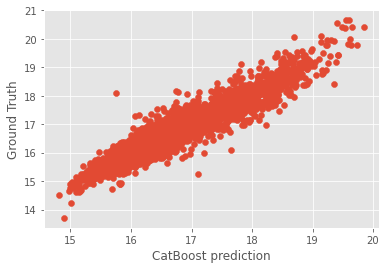

In [16]:
# Plot model performance (done on splitting test data)
plt.scatter(cat_prediction, y_test)
plt.xlabel('CatBoost prediction')
plt.ylabel('Ground Truth')

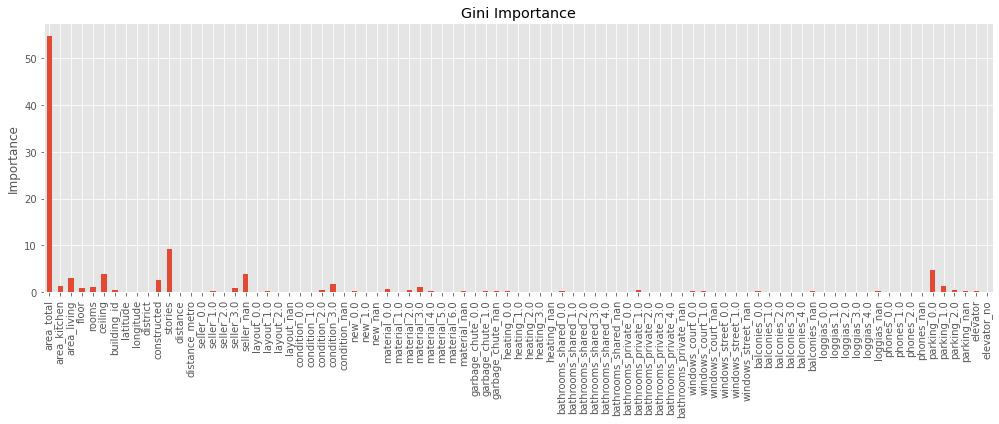

In [17]:
importances = modelCBR.feature_importances_
forest_importances = pd.Series(importances, index=X_train.columns)

fig, ax=plt.subplots(1, 1, figsize=(14,6))
#fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Gini Importance")
ax.set_ylabel("Importance")
fig.tight_layout()

In [18]:
#write_predictions("cat_boost_category_3.csv", XTrain, XTest, cat_prediction_REAL)

In [19]:
#result = pd.read_csv("cat_boost_category_3.csv")
#result.head()

# SECOND RUN

# Removing values that did not give Gini importance

In [20]:
# CLEAN AND MAKE NEW BATCH
X_Train = XTrain.copy()
y_Train = XTrain["price"].copy()
#y_Train = norm_features(y_Train)  # use z-scores to train
y_Train = np.log(y_Train)           # or use log
X_Test = XTest.copy()
drop_features = ["Unnamed: 0", 
                 "id", 
                 "street", 
                 "address"]
X_Train = X_Train.drop(drop_features, axis=1)
X_Train = X_Train.drop("price", axis=1)
X_Test = X_Test.drop(drop_features, axis=1)


X_train = X_Train.copy()
y_train = y_Train.copy()
X_test = X_Test.copy()

In [21]:
# Create new feature of parking
X_train["parking_yes"] = X_train.loc[:,["parking_1.0", 
                                     "parking_2.0"]
                                     ].apply(lambda x: x["parking_1.0"] +
                                             x["parking_2.0"] > 1, 
                                             axis=1)
X_test["parking_yes"] = X_test.loc[:,["parking_1.0", 
                                      "parking_2.0"]
                                   ].apply(lambda x: x["parking_1.0"] +
                                           x["parking_2.0"] > 1,
                                           axis=1)

X_train = X_train.astype({"parking_yes":np.int8})
X_test = X_test.astype({"parking_yes":np.int8})

# Removes are added in tested sequence!!!
drop_second = ["rooms", 
               "material_0.0", "material_1.0", "material_2.0", 
               "material_3.0", "material_4.0", "material_5.0",
               "material_6.0", "material_nan", 
               "balconies_0.0", "balconies_1.0", "balconies_2.0",
               "balconies_3.0", "balconies_4.0", "balconies_nan",
               "loggias_0.0", "loggias_1.0", "loggias_2.0",
               "loggias_3.0","loggias_4.0","loggias_nan",
               "parking_1.0", "parking_2.0",
               "new_0.0", "new_1.0", "new_nan",
               "garbage_chute_0.0", "garbage_chute_1.0", 
               "garbage_chute_nan",
               "elevator", "elevator_no"]

"""
Result mse getting worse when removed 
current best -----------> mse 0.19964 (kaggle: 0.35827) 
    --> best in first --> mse 0.29202 (kaggle: 0.29393)
Conclusion: even if the training model get better scores,
the kaggle get worse!!!

After adjusting area_kitchen to median in building:
mse -------> 0.19924 (only slightly better)

After adjusting area_living to median in building before district:
mse -------> 0.20061 (sligthly worse, but better that first)

Tried skipping:
"parking_nan", "parking_yes"
"layout_0.0", "layout_1.0", 
"layout_2.0", "layout_nan"

Results got worse (so included them again)

"""

X_train = X_train.drop(drop_second, axis=1)
X_test = X_test.drop(drop_second, axis=1)

In [22]:
#X_train.info()

In [23]:
X_tr, X_te, y_tr, y_te = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [24]:
y_tr.head()

18332    16.575520
18707    15.382548
21356    15.645516
19907    16.380460
15697    16.101214
Name: price, dtype: float64

In [25]:
y_te.head()

1603     16.838662
22389    15.887567
4143     16.108045
19962    18.706027
7786     17.296751
Name: price, dtype: float64

In [26]:
modelCBR2 = CatBoostRegressor(n_estimators=1000,
                              learning_rate=0.008,
                              thread_count=-1,
                              depth=7,
                              silent=True,
                              random_seed=42,
                              bagging_temperature=0.2,
                              od_type="Iter")

"""
Using metric = default
Running default (catboost first) on cat_3 data z-score price -> mse x      Kaggle: 0.39163
Running default lgbm on cat_3 data using log on prices -------> mse 0.0773 Kaggle: 0.2992

"""

'\nUsing metric = default\nRunning default (catboost first) on cat_3 data z-score price -> mse x      Kaggle: 0.39163\nRunning default lgbm on cat_3 data using log on prices -------> mse 0.0773 Kaggle: 0.2992\n\n'

In [27]:
modelCBR2.fit(X_tr, y_tr)

In [28]:
# Model prediction on split test set
cat_prediction2 = modelCBR2.predict(X_te)

In [29]:
# Kaggle result running all data in category_3: 0.35557 (worse than first cat boost run)
# Second kaggle: 0.35466 (with better adjusted area_kitchen, _living) --> only sligtly better

cat_mse2 = round(mean_squared_error(cat_prediction2, y_te), 5)
print('Test MSE:', cat_mse2)

Test MSE: 0.08104


In [30]:
# Prediction on the actual test set
cat_prediction_REAL2 = modelCBR2.predict(X_test)

Text(0, 0.5, 'Ground Truth')

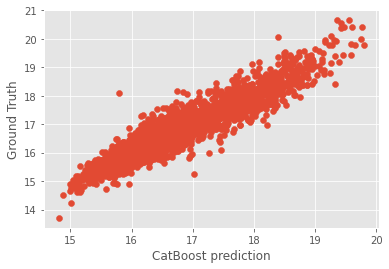

In [31]:
# Plot model performance (done on splitting test data)
plt.scatter(cat_prediction2, y_te)
plt.xlabel('CatBoost prediction')
plt.ylabel('Ground Truth')

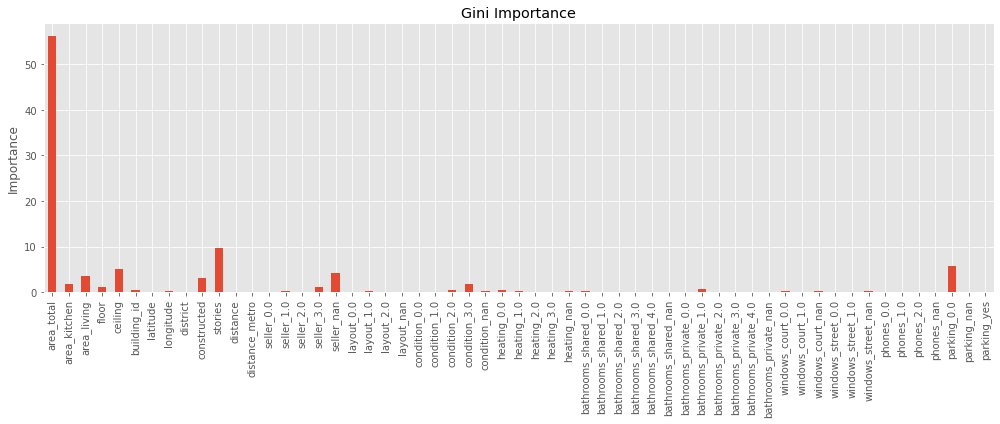

In [32]:
importances = modelCBR2.feature_importances_
forest_importances = pd.Series(importances, index=X_tr.columns)

fig, ax=plt.subplots(1, 1, figsize=(14,6))
#fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Gini Importance")
ax.set_ylabel("Importance")
fig.tight_layout()

In [33]:
print(cat_prediction_REAL2)
print(np.power(cat_prediction_REAL2, 10))

[16.46221415 16.45977552 15.620495   ... 16.15074058 16.00414391
 16.01369554]
[1.46178152e+12 1.45961756e+12 8.64864202e+11 ... 1.20760364e+12
 1.10236263e+12 1.10895947e+12]


In [34]:
# Kaggle score with log prices: 0.2992
write_predictions("cat_boost_2_log_category_3.csv", XTrain, XTest, cat_prediction_REAL2, log=True)

In [35]:
result = pd.read_csv("cat_boost_2_log_category_3.csv")
result.head()

,id,price_prediction
0,23285,1.410746e+07
1,23286,1.407310e+07
2,23287,6.079877e+06
3,23288,1.076812e+07
4,23289,6.210570e+06


In [36]:
XTRAIN = X_train.copy()
y = y_train.copy()   # Already prepared
XTEST = X_test.copy()

In [37]:
X_tr, X_te, y_tr, y_te = train_test_split(XTRAIN, y, test_size=0.2, random_state=42)

In [38]:
modelLGBM = lgb.LGBMRegressor(num_leaves=100,
                              max_depth=15, 
                              random_state=42,
                              metric='mse',
                              n_jobs=4, 
                              n_estimators=3000,
                              colsample_bytree=0.95,
                              subsample=0.9,
                              learning_rate=0.05)

"""
Using metric = "msle"
Running default (from first run of lgbm) on category_3 data --> mse x      Kaggle: 0.39163
Running default lgbm on cat_3 data using log on prices -------> mse 0.0773 Kaggle: 0.29291

"""

'\nUsing metric = "msle"\nRunning default (from first run of lgbm) on category_3 data --> mse x      Kaggle: 0.39163\nRunning default lgbm on cat_3 data using log on prices -------> mse 0.0773 Kaggle: 0.29291\n\n'

In [39]:
modelLGBM.fit(XTRAIN, y)
lgbm_prediction = modelLGBM.predict(X_te)

In [40]:
# Kaggle score on this is: 0.39163
lgbm_mse = round(mean_squared_error(cat_prediction, y_te), 5)
print('Test MSE:', lgbm_mse)

Test MSE: 0.0773


Text(0, 0.5, 'Ground Truth')

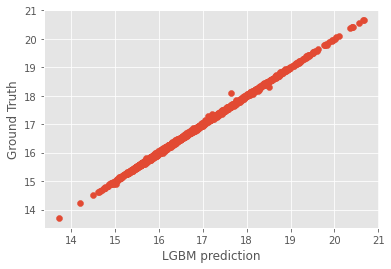

In [41]:
# Plot model performance (done on splitting test data)
plt.scatter(lgbm_prediction, y_te)
plt.xlabel('LGBM prediction')
plt.ylabel('Ground Truth')

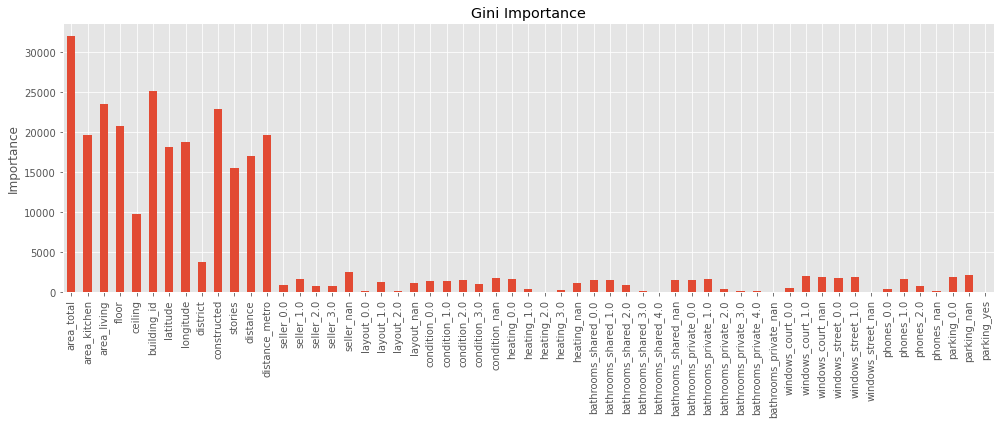

In [42]:
importances = modelLGBM.feature_importances_
forest_importances = pd.Series(importances, index=X_tr.columns)

fig, ax=plt.subplots(1, 1, figsize=(14,6))
#fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Gini Importance")
ax.set_ylabel("Importance")
fig.tight_layout()

In [43]:
# Kaggle score: 0.39163 (worse than cat boost) using z-score prices
# Kaggle score with log: 0.29291 
# Kaggle score with catboost and log prices: 0.2992 (sligthly worse that lgbm)

lgbm_prediction_final = modelLGBM.predict(XTEST)

In [44]:
write_predictions("lgbm_boost_log_category_3.csv", XTrain, XTest, lgbm_prediction_final, log=True)

In [45]:
result = pd.read_csv("lgbm_boost_log_category_3.csv")
result.head()

,id,price_prediction
0,23285,1.553361e+07
1,23286,1.301201e+07
2,23287,6.964845e+06
3,23288,7.468174e+06
4,23289,7.287342e+06


In [46]:
l_price = np.exp(lgbm_prediction_final)
print(l_price)

[15533613.3861025  13012005.07800746  6964844.9274651  ...
  8874669.02034623  8018297.29695338  7412685.84065156]


In [47]:
XTrain["price"].head()

0     7139520.0
1    10500000.0
2     9019650.0
3    10500000.0
4    13900000.0
Name: price, dtype: float64

In [48]:
log_price = np.log(XTrain["price"])
log_price.head()

0    15.781156
1    16.166886
2    16.014916
3    16.166886
4    16.447399
Name: price, dtype: float64

In [49]:
log_price_revert = np.exp(log_price)
log_price_revert.head()

0     7139520.0
1    10500000.0
2     9019650.0
3    10500000.0
4    13900000.0
Name: price, dtype: float64

In [50]:
z_price = norm_features(XTrain["price"])
z_price.head()

0   -0.311843
1   -0.248009
2   -0.276129
3   -0.248009
4   -0.183424
Name: price, dtype: float64

In [51]:
z_price_reverted = revert(XTrain, z_price)
z_price_reverted.head()

0     7139520.0
1    10500000.0
2     9019650.0
3    10500000.0
4    13900000.0
Name: price, dtype: float64

In [52]:
log_price.max()

21.678777281973847

In [53]:
z_price.max()

48.94094976711498

In [54]:
log_price.min()

13.710150042306449

In [55]:
z_price.min()

-0.4303663197876889

In [56]:
z_price.mean()

1.7490005817073718e-16

In [57]:
z_price.median()

-0.24525473322380809

<AxesSubplot:>

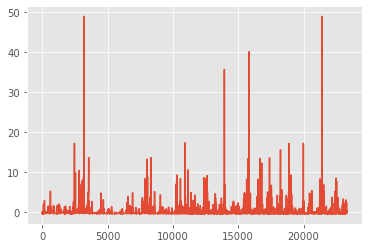

In [58]:
z_price.plot()

<AxesSubplot:>

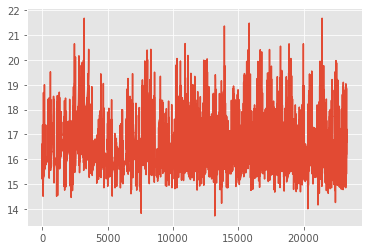

In [59]:
log_price.plot()

In [60]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.datasets import make_regression
from lightgbm import LGBMRegressor
# define dataset
X, y = make_regression(n_samples=1000, n_features=20, n_informative=15, noise=0.1, random_state=7)
# define the model
model = LGBMRegressor()
# evaluate the model
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('MAE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

MAE: -60.004 (2.887)


In [61]:
model.fit(X, y)
# make a single prediction
row = [0.20543991,-0.97049844,-0.81403429,-0.23842689,-0.60704084,-0.48541492,0.53113006,2.01834338,-0.90745243,-1.85859731,-1.02334791,-0.6877744,0.60984819,-0.70630121,-1.29161497,1.32385441,1.42150747,1.26567231,2.56569098,-0.11154792]
yhat = model.predict([row])
print('Prediction: %d' % yhat[0])

Prediction: 52


In [62]:

# xgboost for regression
from sklearn.datasets import make_regression
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from matplotlib import pyplot
# define dataset
X, y = make_regression(n_samples=1000, n_features=10, n_informative=5, random_state=1)
# evaluate the model
model = XGBRegressor(objective='reg:squarederror')
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
print('MAE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))
# fit the model on the whole dataset
model = XGBRegressor(objective='reg:squarederror')
model.fit(X, y)
# make a single prediction
row = [2.02220122, 0.31563495, 0.82797464, -0.30620401, 0.16003707, -1.44411381, 0.87616892, -0.50446586, 0.23009474, 0.76201118]
row = np.asarray(row).reshape((1, len(row)))
yhat = model.predict(row)
print('Prediction: %.3f' % yhat[0])

MAE: -15.048 (1.316)
Prediction: -93.434
